In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import warnings

warnings.filterwarnings("ignore")

# Start the spark context
sc = SparkContext.getOrCreate(conf=swan_spark_conf) 
print("Created Spark Context")

# create a spark session (which will run spark jobs)
spark = SparkSession.builder.getOrCreate()
print("Created Spark Session")

#  set good looking dataframes
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
print("Set Good Looking Dataframes")

# use Apache Arrow
spark.conf.set('spark.sql.execution.arrow.pyspark.enabled', True)
print("Using Apache Arrow")

In [ ]:
sdfWeekdays = spark.read.parquet('./preprocessed_data/weekdayRemovedInvalids.parquet')
sdfWeekends = spark.read.parquet('./preprocessed_data/weekendsRemovedInvalids.parquet')
sdfZoneLookup = spark.read.csv('./raw_data/taxi_zone_lookup.csv', header=True)

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql import DataFrame as D

ints = ['LocationID']
strings = ('Borough', 'Zone', 'service_zone')
dtypes = {column: IntegerType() for column in ints}
dtypes.update({column: StringType() for column in strings})

setSchema = StructType()
for column in sdfZoneLookup.columns:
    setSchema.add(column,
                  dtypes[column],
                  True)
    
sdfZoneLookup = spark.read.csv('./raw_data/taxi_zone_lookup.csv', header=True, schema=setSchema)

In [ ]:
print(sdfZoneLookup.select('LocationID').distinct().count())

#There are 265 LocationIDs but the data dictionary tells us there should only be 263

print(sdfZoneLookup.orderBy('LocationID').tail(5))

#On closer inspection, zones 264 and 265 seem to be invalid -> We drop them

sdfZoneLookup = sdfZoneLookup.filter(sdfZoneLookup.LocationID.isin(list(range(1,264))))

In [ ]:
def zoneExpectedEarnings(sdf, weekend):
    sdfZoneDailyPU = sdf.groupBy("PUDate", "PULocationID").count()
    sdfZoneAvgDailyPU = sdfZoneDailyPU.groupBy("PULocationID").sum("count")
    if (weekend):
        sdfZoneAvgDailyPU = sdfZoneAvgDailyPU.withColumn("AvgDailyPU", sdfZoneAvgDailyPU['sum(count)'] / 40.0) \
        .drop("sum(count)")
    else:
        sdfZoneAvgDailyPU = sdfZoneAvgDailyPU.withColumn("AvgDailyPU", sdfZoneAvgDailyPU['sum(count)'] / 52.0) \
        .drop("sum(count)")
    
    sdfZoneDailyAvg = sdf.groupBy("PUDate","PULocationID").avg('total_amount')
    sdfZoneAvgDailyTot = sdfZoneDailyAvg.groupBy("PULocationID").sum("avg(total_amount)")
    if (weekend):
        sdfZoneAvgDailyTot = sdfZoneAvgDailyTot.withColumn("ExpectedDailyAvg", 
                                                           sdfZoneAvgDailyTot["sum(avg(total_amount))"] / 40.0) \
        .drop("sum(avg(total_amount))")
    else:
        sdfZoneAvgDailyTot = sdfZoneAvgDailyTot.withColumn("ExpectedDailyAvg", 
                                                           sdfZoneAvgDailyTot["sum(avg(total_amount))"] / 52.0) \
        .drop("sum(avg(total_amount))")
    
    
    sdfExpEarnings = sdfZoneAvgDailyTot.join(sdfZoneAvgDailyPU, 
                                             sdfZoneAvgDailyTot.PULocationID == sdfZoneAvgDailyPU.PULocationID, 
                                             "inner") \
    .drop(sdfZoneAvgDailyPU.PULocationID)
    
    sdfExpEarnings = sdfExpEarnings.withColumn("ExpectedEarnings",
                                                sdfExpEarnings.ExpectedDailyAvg * sdfExpEarnings.AvgDailyPU)\
    .drop("AvgDailyPU")\
    .drop("ExpectedDailyAvg")
    
    sdfExpEarnings = sdfExpEarnings.join(sdfZoneLookup, 
                                         sdfZoneLookup.LocationID == sdfExpEarnings.PULocationID, 
                                         "inner") \
    .drop("Zone") \
    .drop("service_zone") \
    .drop("LocationID")
    
    sdfExpEarnings = sdfExpEarnings.withColumn("logEE", F.log(sdfExpEarnings.ExpectedEarnings))
    
    return sdfExpEarnings

dfWDExpEarnings = zoneExpectedEarnings(sdfWeekdays, False).toPandas()
dfWEExpEarnings = zoneExpectedEarnings(sdfWeekends, True).toPandas()

In [ ]:
import geopandas as gpd
import pandas as pd
import folium

sf = gpd.read_file("./raw_data/taxi_zones/taxi_zones.shp")
pdZoneLookup = sdfZoneLookup.toPandas()

# Following line of code taken from Lab 2 of MAST30034 and converts the shapefile boundaries to coordinates
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [ ]:
gdf = gpd.GeoDataFrame(pd.merge(dfWDExpEarnings, sf, left_on='PULocationID', right_on='LocationID')).drop('LocationID',axis=1)
WDGeoJSON = gdf[['PULocationID','geometry']].drop_duplicates('PULocationID').to_json()

m = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m.add_child(folium.Choropleth(geo_data= WDGeoJSON, 
                              data= dfWDExpEarnings,
                              columns=['PULocationID', 'logEE'],
                              key_on='feature.properties.PULocationID', 
                              threshold_scale = [-6, -1, 4, 7, 10, 13],
                              fill_color = 'YlGnBu'))

m.save('./plots/weekdaysEEMap.html')

In [ ]:
gdf2 = gpd.GeoDataFrame(pd.merge(dfWEExpEarnings, sf, left_on='PULocationID', right_on='LocationID')).drop('LocationID',axis=1)
WEGeoJSON = gdf2[['PULocationID','geometry']].drop_duplicates('PULocationID').to_json()

m2 = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
m2.add_child(folium.Choropleth(geo_data= WEGeoJSON, 
                              data= dfWEExpEarnings,
                              columns=['PULocationID', 'logEE'],
                              key_on='feature.properties.PULocationID',
                              threshold_scale = [-6, -1, 4, 7, 10, 13],
                              fill_color = 'YlGnBu'))

m2.save('./plots/weekendsEEMap.html')

In [ ]:
from matplotlib import *

dfWDExpEarnings['Weekend'] = 'Weekday'
dfWEExpEarnings['Weekend'] = 'Weekend'

concatEE = pd.concat([dfWDExpEarnings, dfWEExpEarnings])

bxplt = concatEE[['logEE', 'Weekend']].boxplot(by="Weekend")
bxplt.set_title("Log Transform of Expected Earnings Weekdays vs Weekends")
bxplt.get_figure().suptitle('')

pyplot.savefig("./plots/logEE.jpg", bbox_inches = 'tight')

In [ ]:
sdfWeather = spark.read.csv('./raw_data/weather_data_JunToAug.csv', header=True)

laguardiaCode = "USW00014732"

doubles = ('LATITUDE', 'LONGITUDE', 'ELEVATION', 'AWND', 'PRCP', 
           'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN')
strings = ('STATION', 'NAME')
dates = ['DATE']
dtypes = {column: DoubleType() for column in doubles}
dtypes.update({column: StringType() for column in strings})
dtypes.update({column: DateType() for column in dates})

setSchema = StructType()
for column in sdfWeather.columns:
    setSchema.add(column,
                  dtypes[column],
                  True)
    
sdfWeather = spark.read.csv('./raw_data/weather_data_JunToAug.csv', header=True, schema=setSchema)

sdfWeather = sdfWeather.drop("NAME") \
.drop('LATITUDE') \
.drop('LONGITUDE') \
.drop("ELEVATION") \
.filter(sdfWeather.STATION == laguardiaCode)

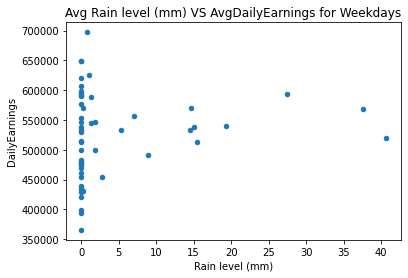

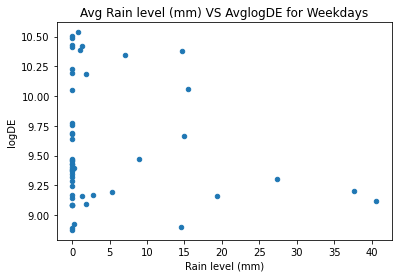

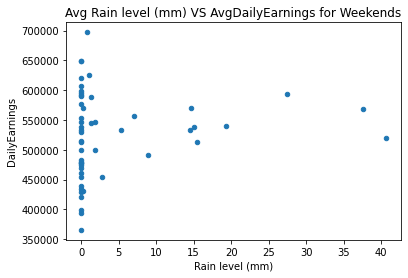

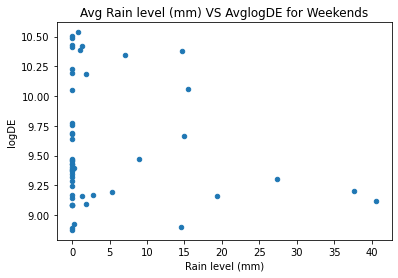

In [81]:
def borDailyEarnings(sdf):
    sdf2 = sdf.join(sdfZoneLookup, sdfZoneLookup.LocationID == sdf.PULocationID, "inner") \
    .drop("Zone") \
    .drop("service_zone") \
    .drop("LocationID")
    
    sdfBorDailyPU = sdf2.groupBy("PUDate", "Borough").count()
    
    sdfBorDailyPU = sdfBorDailyPU.join(sdfWeather, sdfWeather.DATE == sdfBorDailyPU.PUDate, "inner") \
    .drop("DATE") \
    .drop("STATION")
    
    sdfBorAvgTot = sdf2.groupBy("PUDate", "Borough").avg("total_amount")
    sdfBorAvgTot = sdfBorAvgTot.withColumnRenamed("avg(total_amount)", "AvgTot")
    
    sdfBor = sdfBorAvgTot.join(sdfBorDailyPU, 
                               ((sdfBorAvgTot.PUDate == sdfBorDailyPU.PUDate) & 
                                (sdfBorAvgTot.Borough == sdfBorDailyPU.Borough)), 
                               "inner") \
    .drop(sdfBorAvgTot.PUDate) \
    .drop(sdfBorAvgTot.Borough)
    
    sdfBor = sdfBor.withColumn("DailyEarnings",
                               sdfBor["count"] * sdfBor["AvgTot"])\
    .drop("count")\
    .drop("AvgTot")
    
    sdfBor = sdfBor.withColumn("logDE", F.log(sdfBor.DailyEarnings))
    
    return sdfBor


def PRCPvsX(sdf, X, Week):
    sdfWDAvgDayX = sdfBorWeekdays.groupBy("PUDate").avg(X)
    sdfWDAvgDayPrcp = sdfBorWeekdays.groupBy("PUDate").avg("PRCP")
    dfWDAvgDay = sdfWDAvgDayX.join(sdfWDAvgDayPrcp, 
                                   sdfWDAvgDayPrcp.PUDate == sdfWDAvgDayX.PUDate, 
                                   "inner") \
    .drop(sdfWDAvgDayX.PUDate) \
    .toPandas()

    plot = dfWDAvgDay.plot.scatter(x = "avg(PRCP)", y = "avg(" + X + ")")
    plot.set(title = "Avg Rain level (mm) VS Avg" + X + " for " + Week,
             xlabel = "Rain level (mm)",
             ylabel = X)
    
    figure = plot.get_figure()
    figure.savefig('./plots/'+Week+X+'.jpg', bbox_inches='tight')

sdfBorWeekdays = borDailyEarnings(sdfWeekdays)
PRCPvsX(sdfBorWeekdays, "DailyEarnings", "Weekdays")
PRCPvsX(sdfBorWeekdays, "logDE", "Weekdays")
sdfBorWeekends = borDailyEarnings(sdfWeekends)
PRCPvsX(sdfBorWeekends, "DailyEarnings", "Weekends")
PRCPvsX(sdfBorWeekends, "logDE", "Weekends")

In [82]:
sdfBorWeekdays.write.format('parquet').save('./preprocessed_data/WDBorLinkedWeather.parquet')
sdfBorWeekends.write.format('parquet').save('./preprocessed_data/WEBorLinkedWeather.parquet')

21/08/10 14:14:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
21/08/10 14:14:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
21/08/10 14:14:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
21/08/10 14:14:38 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
